In [1]:
from PIL import Image
import os, glob, cv2, random
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import applications, optimizers, losses, layers
from tensorflow.keras.layers import Input, concatenate, Dense, LeakyReLU, UpSampling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
ramdom_seed = 4885
tf.random.set_random_seed(ramdom_seed)
np.random.seed(ramdom_seed)
random.seed(ramdom_seed)

In [3]:
def SSIM_cs(y_true, y_pred):
    patches_true = tf.extract_image_patches(y_true, [1, 8, 8, 1], [1, 2, 2, 1], [1, 1, 1, 1], "SAME")
    patches_pred = tf.extract_image_patches(y_pred, [1, 8, 8, 1], [1, 2, 2, 1], [1, 1, 1, 1], "SAME")

    var_true = K.var(patches_true, axis=3)
    var_pred = K.var(patches_pred, axis=3)
    std_true = K.sqrt(var_true)
    std_pred = K.sqrt(var_pred)
    c2 = 0.03 ** 2
    ssim = (2 * std_pred * std_true + c2)
    denom = (var_pred + var_true + c2)
    ssim /= denom
    ssim = tf.where(tf.is_nan(ssim), K.zeros_like(ssim), ssim)
    return 1 - K.mean(ssim)

In [4]:
def augment_image_colorspace(image):
    # input shape [h, w * seq , c]
    random_gamma = random.uniform(0.8,1.2)
    random_brightness = random.uniform(0.5, 2.0)
    random_colors = [random.uniform(0.8,1.2), random.uniform(0.8,1.2), random.uniform(0.8,1.2)]
    # Randomly shift gamma.
    image_aug = image**random_gamma
    # Randomly shift brightness. 
    image_aug *= random_brightness
    # Randomly shift color. 
    white = np.ones([image.shape[0], image.shape[1]])
    color_image = np.stack([white * random_colors[i] for i in range(3)], axis=2)
    image_aug *= color_image
    # Saturate.
    image_aug = np.clip(image_aug, 0, 1)
    return image_aug

In [5]:
def data_generator(data_path, batch, aug):
    dir_list = os.listdir(data_path)
    img_list = []
    for j in dir_list:
        img_path = os.path.join(data_path, j)
        tmp_list = sorted(glob.glob(img_path +'/*.png'))
        img_list += tmp_list
    idx = 0
    while 1:
        idx_list = list(range(0,len(img_list)))
        random.shuffle(idx_list)
        bat_img = []
        bat_lab = []
        if idx > len(idx_list) - batch:
            idx = idx_list[idx:]
            idx = 0
        else:
            tmp_list = idx_list[idx:idx+batch]
            idx = idx + batch
            
        for i in tmp_list:
            img_tmp = cv2.imread(img_list[i])
            
            if img_tmp is None:
                print(img_list[i])
            if aug == 1:    
                img = augment_image_colorspace(cv2.cvtColor(img_tmp[:,:256,:],cv2.COLOR_BGR2RGB)/255.)
            else:
                img = cv2.cvtColor(img_tmp[:,:256,:],cv2.COLOR_BGR2RGB)/255.
            lab = cv2.cvtColor(img_tmp[:,256:,:], cv2.COLOR_BGR2GRAY)/255.
            bat_img.append(img)
            bat_lab.append(lab) 
        yield np.array(bat_img), [np.expand_dims(np.array([cv2.resize(i, (256, 256)) for i in bat_lab]),axis = -1),
                                 np.expand_dims(np.array([cv2.resize(i, (128, 128)) for i in bat_lab]),axis = -1),
                                 np.expand_dims(np.array([cv2.resize(i, (64, 64)) for i in bat_lab]),axis = -1),
                                 np.expand_dims(np.array([cv2.resize(i, (32, 32)) for i in bat_lab]),axis = -1),]

In [6]:
def generator(inputs):
    conv1 = Conv2D(64, 7, padding = 'same', strides=(2, 2), activation = 'relu')(inputs)
    conv2 = Conv2D(128, 5,  padding = 'same', strides=(2, 2), activation = 'relu')(conv1)
    conv3 = Conv2D(256, 5,  padding = 'same', strides=(2, 2), activation = 'relu')(conv2)
    conv3_1 = Conv2D(256, 3, padding = 'same', strides=(1, 1), activation = 'relu')(conv3)
    conv4 = Conv2D(512, 3,  padding = 'same', strides=(2, 2), activation = 'relu')(conv3_1)
    conv4_1 = Conv2D(512, 3,  padding = 'same', strides=(1, 1), activation = 'relu')(conv4)
    conv5 = Conv2D(512, 3,  padding = 'same', strides=(2, 2), activation = 'relu')(conv4_1)
    conv5_1 = Conv2D(512, 3, padding = 'same', strides=(1, 1), activation = 'relu')(conv5)
    
    deconv5 = Conv2D(512, 3, padding = 'same', use_bias=False, strides=(1, 1), activation = 'relu')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(conv5_1))
    deconv4 = Conv2D(256, 3, padding = 'same', use_bias=False, strides=(1, 1), activation = 'relu')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(deconv5))
    merge4 = concatenate([deconv4,conv3], axis = 3)    
    aux3 = Conv2D(1, 3, padding = 'same', use_bias =False, strides=(1, 1), activation = 'sigmoid')(merge4)
    deconv3 = Conv2D(128, 3, padding = 'same', use_bias=False, strides=(1, 1), activation = 'relu')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(merge4))
    merge3 = concatenate([deconv3,conv2], axis = 3)
    aux2 = Conv2D(1, 3, padding = 'same', use_bias =False, strides=(1, 1), activation = 'sigmoid')(merge3)
    deconv2 = Conv2D(64, 3, padding = 'same', use_bias=False, strides=(1, 1), activation = 'relu')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(merge3))
    merge2 = concatenate([deconv2,conv1], axis = 3)
    aux1 = Conv2D(1, 3, padding = 'same', use_bias =False, strides=(1, 1), activation = 'sigmoid')(merge2)
    deconv1 = Conv2D(64, 3, padding = 'same', use_bias=False, strides=(1, 1), activation = 'relu')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(merge2))
    output = Conv2D(1, 3, activation = 'sigmoid', padding = 'same')(deconv1)
    
    model = Model(inputs = inputs, outputs = [output, aux1, aux2, aux3])
    return model

In [7]:
gen_input = Input(shape=(256,256,3))
model = generator(gen_input)
model.compile(optimizer = Adam(lr = 0.0002), loss = [SSIM_cs,SSIM_cs,SSIM_cs,SSIM_cs], loss_weights = [0.64, 0.16, 0.04, 0.01])

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 128)  204928      conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 256)  819456      conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [9]:
#model = tf.keras.models.load_model('checkpoints/cv_sc_epochs12.h5')

In [10]:
train_path = '/data1/depth/endo_sim2/train/'
batch = 32
train = data_generator(train_path, batch, 1)
val_path = '/data1/depth/endo_sim2/val/'
batch = 32
val = data_generator(val_path, batch, 0)

In [11]:
dir_list = os.listdir(train_path)
train_img_list = []
for j in dir_list:
    img_path = os.path.join(train_path, j)
    tmp_list = sorted(glob.glob(img_path +'/*.png'))
    train_img_list += tmp_list
    
print(len(train_img_list))

21981


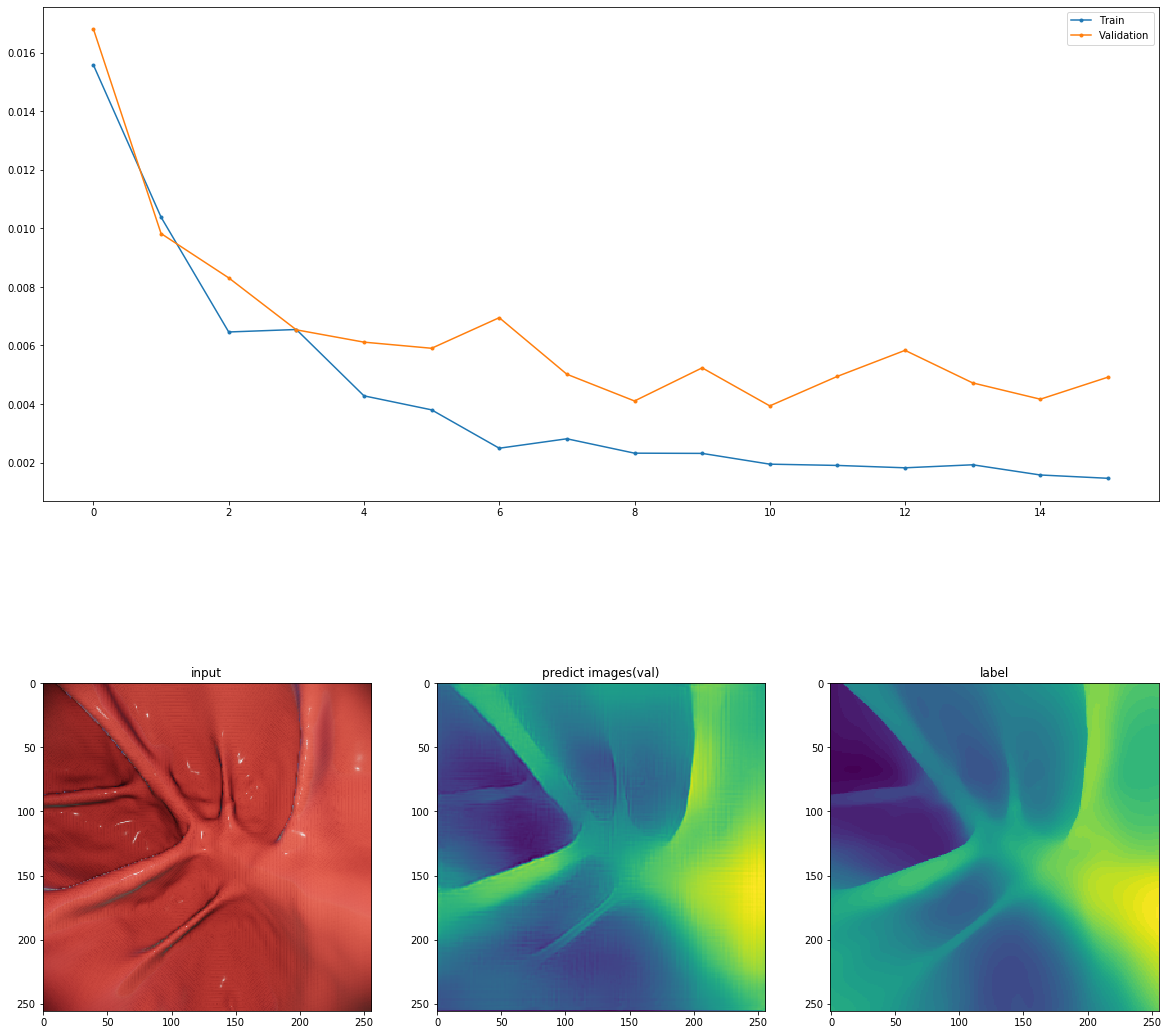

In [12]:
model_name = 'cv_dcv_aux'
scale = 10
steps = int(np.ceil(len(train_img_list)/batch))
epochs = 16

total_loss = []
val_total_loss = []

for epoch in range(epochs):
    for step in range(steps):
        train_img, train_lab = next(train)
        loss = model.train_on_batch(train_img, train_lab)
    total_loss.append(loss[0])
    val_img, val_lab = next(val)
    val_loss = model.evaluate(val_img, val_lab)
    
    val_total_loss.append(val_loss[0])
    plt.cla()
    plt.clf()
    plt.close()
    clear_output(wait=True)
    val_p = model.predict(val_img)
    
    
    plt.figure(figsize=(20, 20))
    plt.subplot(211)
    plt.plot(total_loss,'.-')
    plt.plot(val_total_loss,'.-')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.subplot(234)
    plt.imshow(val_img[0])
    plt.title("input")
    plt.subplot(235)
    plt.imshow(1-np.reshape(val_p[0][0]*scale, (256,256)), cmap = 'viridis')
    plt.title("predict images(val)")
    plt.subplot(236)
    plt.imshow(1-np.reshape(val_lab[0][0]*scale, (256,256)), cmap = 'viridis')
    plt.title("label")
    plt.show()
    if epoch % 5 == 0:
        model_path = "checkpoints_cv_ssim/test_%s_%02d_%.5f.h5"%(model_name, epoch+1, loss[0])
        model.save_weights(model_path)

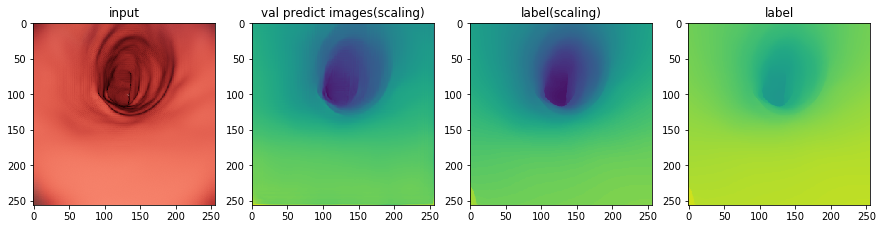

In [13]:
scale = 2

test_img, test_lab= next(val)
test_p = model.predict(test_img)
plt.figure(figsize=(15, 15))
plt.subplot(141)
plt.imshow(test_img[0])
plt.title("input")
plt.subplot(142)
plt.imshow(1-np.reshape(test_p[0][0]*scale,(256,256)),vmin = 0, vmax = 1, cmap = 'viridis')
plt.title("val predict images(scaling)")
plt.subplot(143)
plt.imshow(1-np.reshape(test_lab[0][0]*scale,(256,256)),vmin = 0, vmax = 1, cmap = 'viridis')
plt.title("label(scaling)")
plt.subplot(144)
plt.imshow(1-np.reshape(test_lab[0][0], (256,256)),vmin = 0, vmax = 1, cmap = 'viridis')
plt.title("label")
plt.show()

In [14]:
test_path = '/data1/depth/endo_sim2/test/'
batch = 32
test = data_generator(test_path, batch, 0)

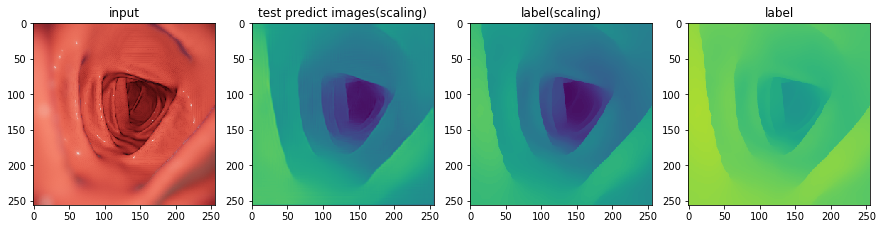

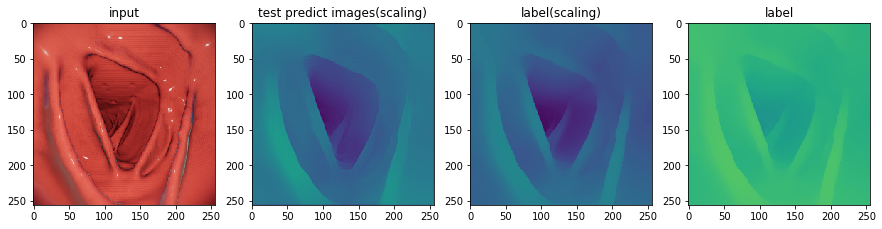

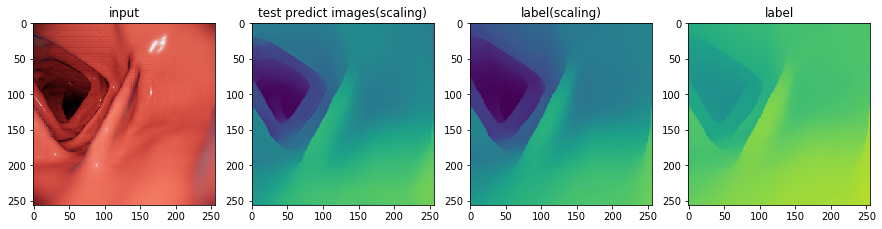

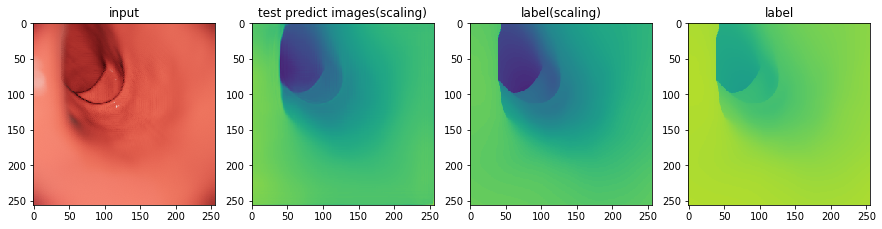

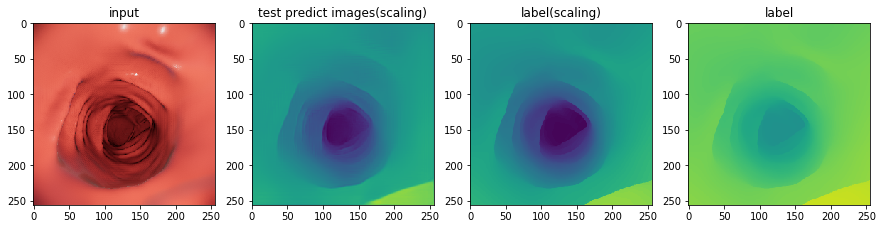

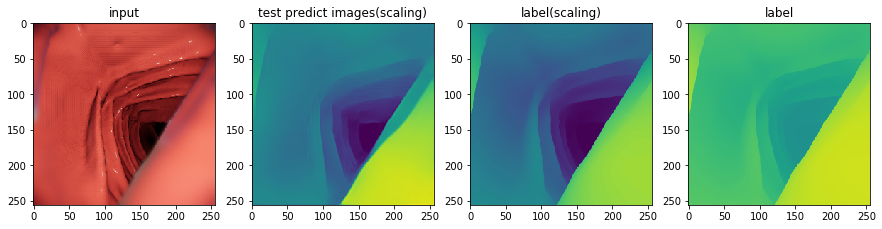

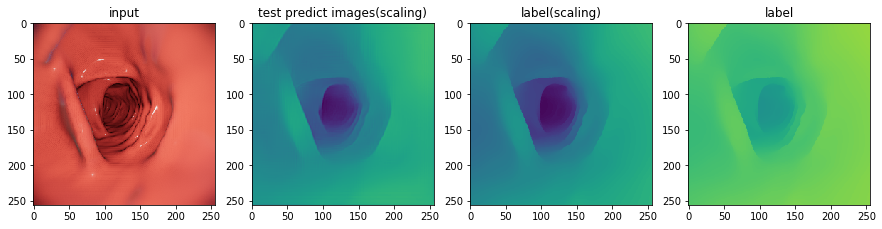

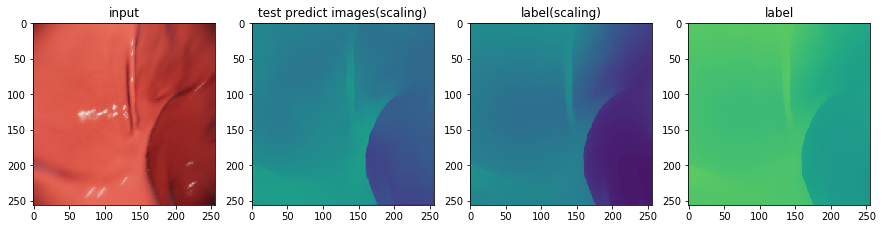

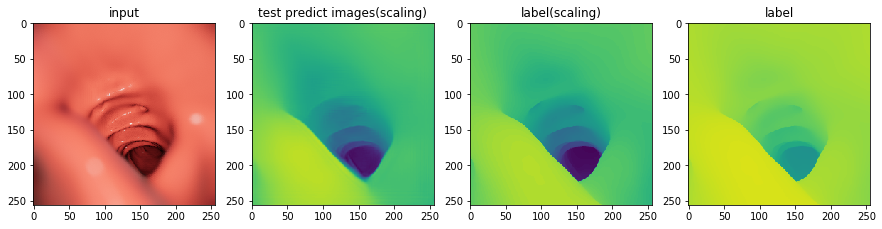

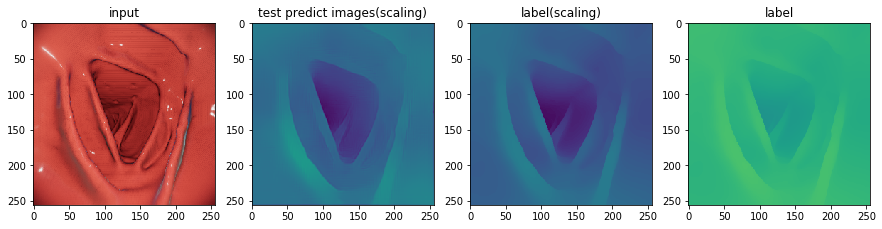

In [24]:
scale = 2
for i in range(10):
    test_img, test_lab= next(test)
    test_p = model.predict(test_img)
    plt.figure(figsize=(15, 15))
    plt.subplot(141)
    plt.imshow(test_img[0])
    plt.title("input")
    plt.subplot(142)
    plt.imshow(1-np.reshape(test_p[0][0]*scale,(256,256)),vmin = 0, vmax = 1, cmap = 'viridis')
    plt.title("test predict images(scaling)")
    plt.subplot(143)
    plt.imshow(1-np.reshape(test_lab[0][0]*scale,(256,256)),vmin = 0, vmax = 1, cmap = 'viridis')
    plt.title("label(scaling)")
    plt.subplot(144)
    plt.imshow(1-np.reshape(test_lab[0][0], (256,256)),vmin = 0, vmax = 1, cmap = 'viridis')
    plt.title("label")
    plt.show()

In [25]:
from skimage.measure import compare_mse as mse
from skimage.measure import compare_nrmse as nrmse
from skimage.measure import compare_psnr as psnr
from skimage.measure import compare_ssim as ssim

In [26]:
nrmse_ = []
mse_ = []
psnr_ = []
ssim_ = []

for i in range(100):
    test_img, test_lab= next(test)
    tmp_test = model.predict(test_img)
    tmp_test = tmp_test[0][0]
    tmp_test = tmp_test.astype('float64')
    nrmse_.append(nrmse(tmp_test, test_lab[0][0]))
    mse_.append(mse(tmp_test, test_lab[0][0]))
    psnr_.append(psnr(tmp_test, test_lab[0][0]))
    ssim_.append(ssim(tmp_test, test_lab[0][0], multichannel=True))

In [27]:
print('rmse : ', np.array(nrmse_).mean())
print('mse : ', np.array(mse_).mean())
print('psnr : ', np.array(psnr_).mean())
print('ssim : ', np.array(ssim_).mean())

rmse :  0.10009504585912272
mse :  0.000646744963063369
psnr :  33.354381501867145
ssim :  0.9872273787974588


In [19]:
path = '/data1/depth/endo/endo/endo_ori/train/'
dir_list = os.listdir(path)
dir_list.sort()

In [20]:
total_list = []
for j in dir_list:
    frame_list = glob.glob(os.path.join(path, j, '*.png'))
    total_list += frame_list

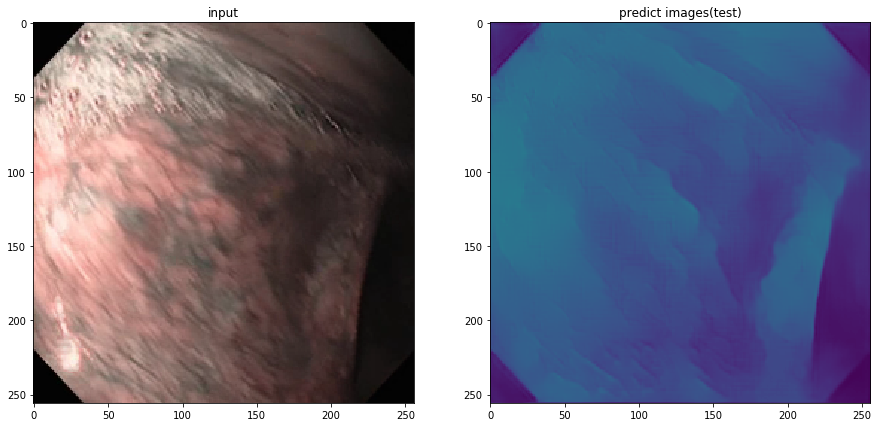

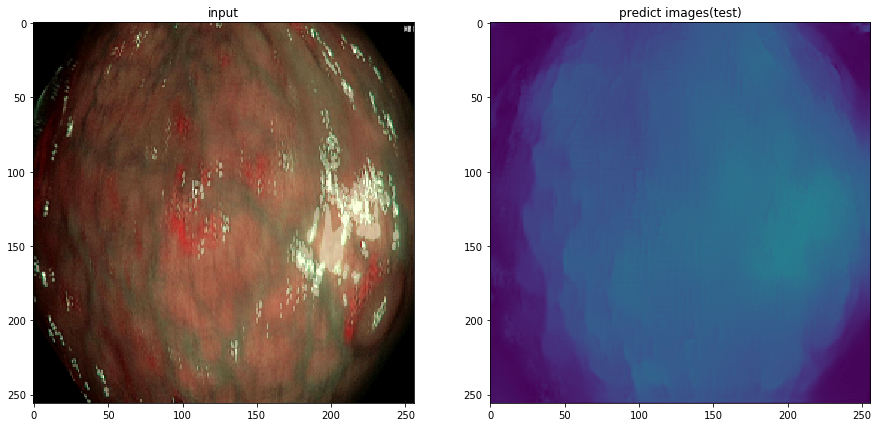

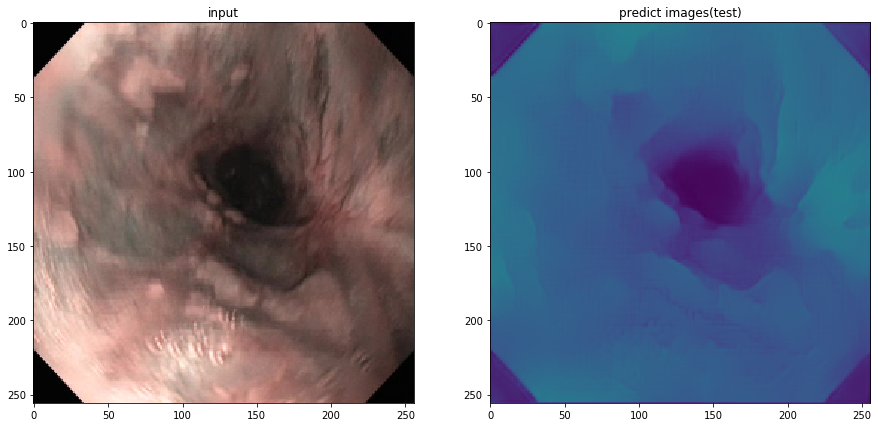

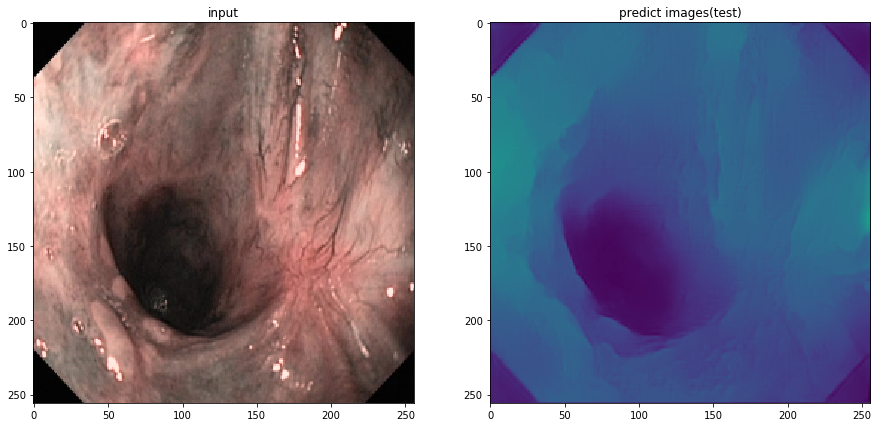

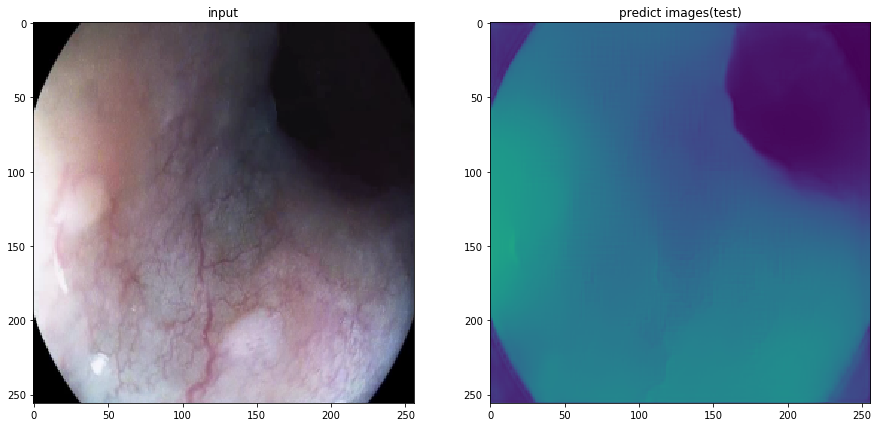

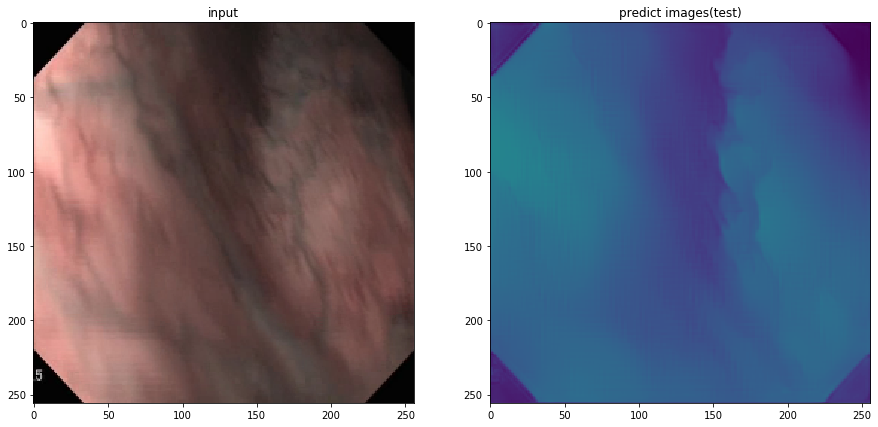

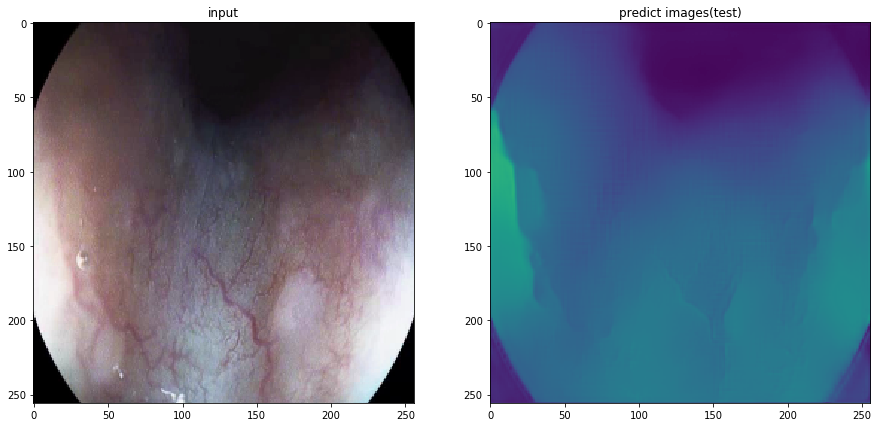

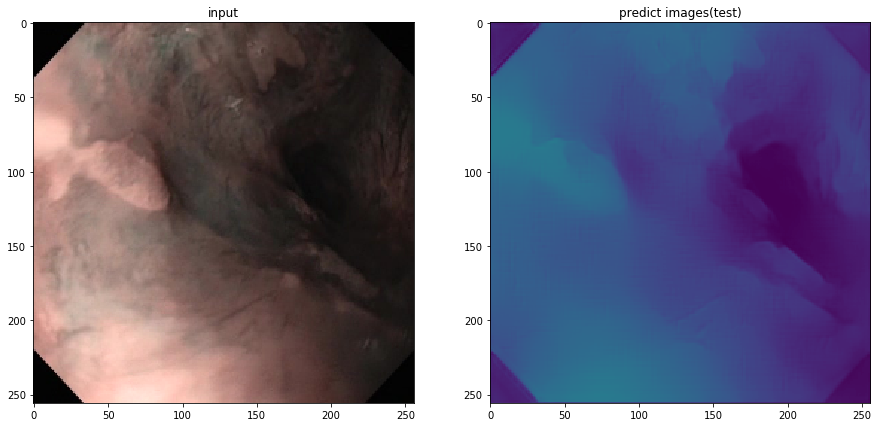

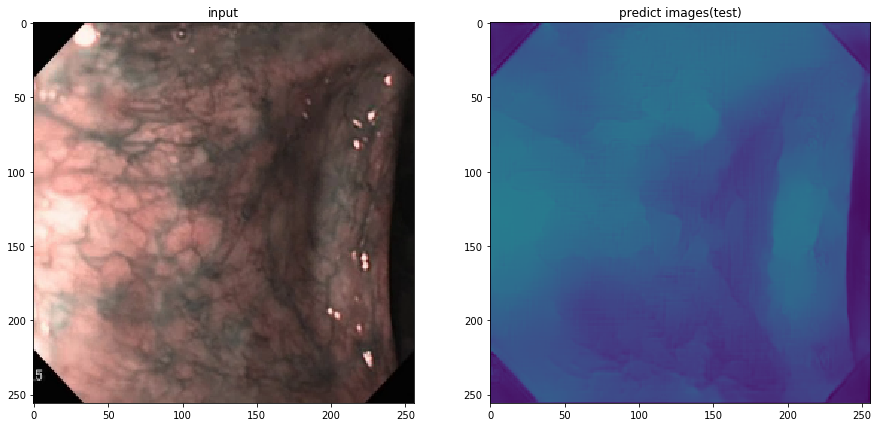

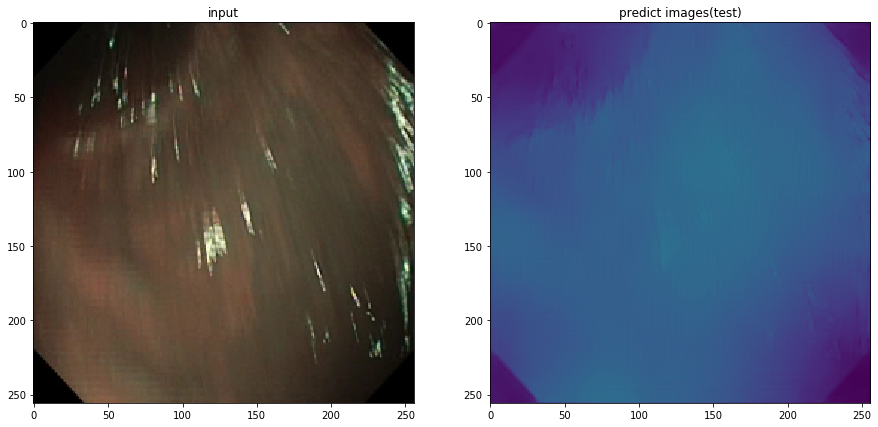

In [21]:
rand_list = random.sample(total_list, 10)
for tmp in rand_list:
    img = np.expand_dims(cv2.resize(np.array(Image.open(tmp))/255., (256,256)), axis=0)
    test_p = model.predict(img)
    plt.figure(figsize=(15, 15))
    plt.subplot(121)
    plt.imshow(img[0])
    plt.title("input")
    plt.subplot(122)
    plt.imshow(1-np.reshape(test_p[0][0]*scale,(256,256)),vmin = 0, vmax = 1, cmap = 'viridis')
    plt.title("predict images(test)")
    plt.show()

In [22]:
path = '/data1/GIANA/Detection/jerry/raw_image/'
dir_list = os.listdir(path)
dir_list.sort()

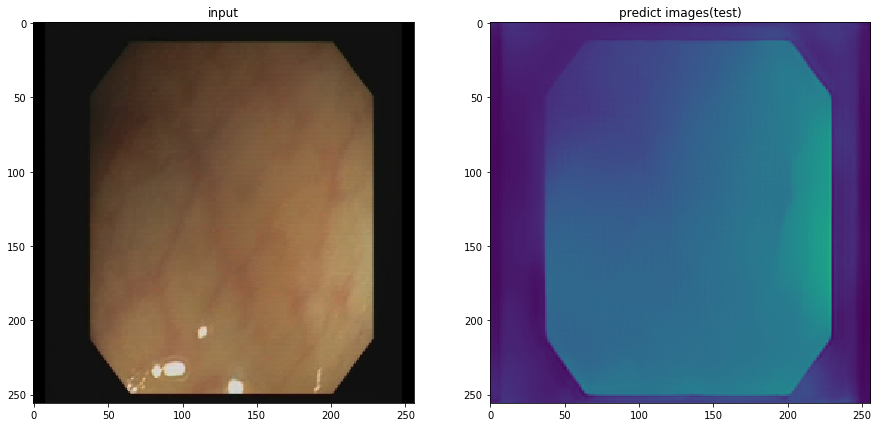

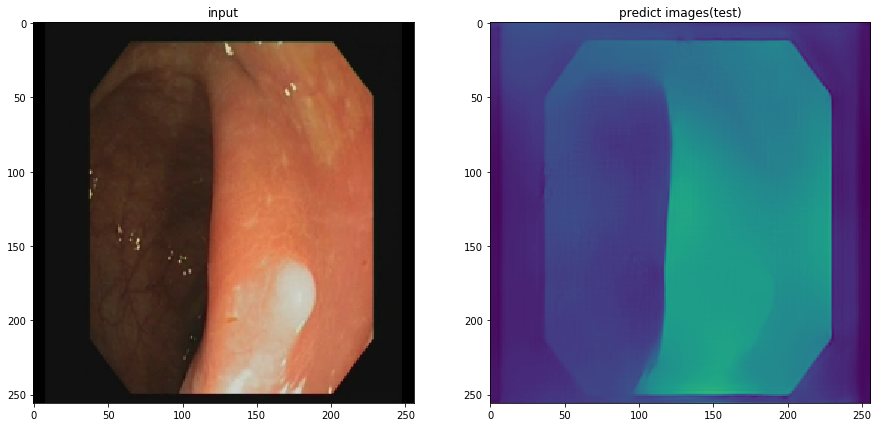

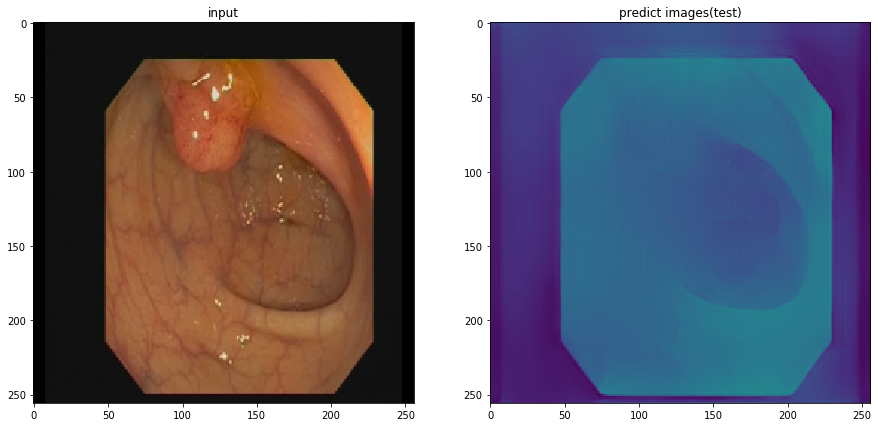

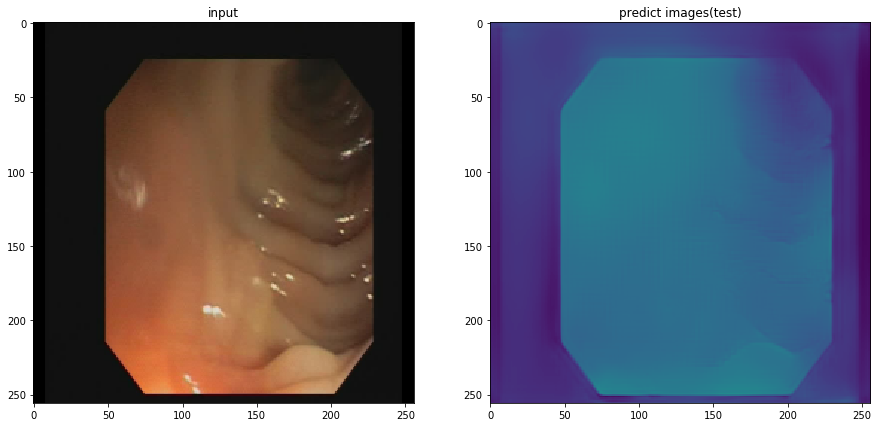

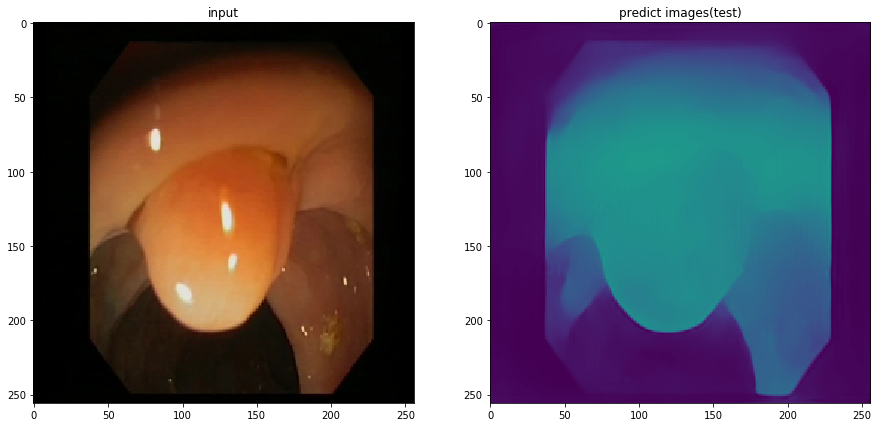

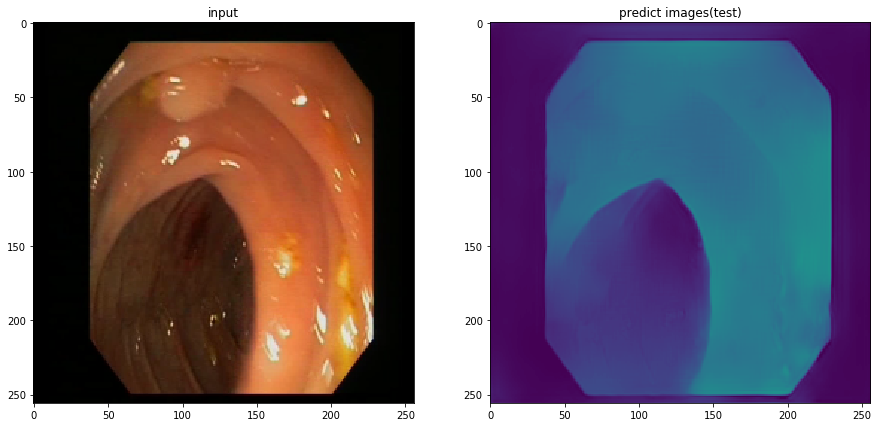

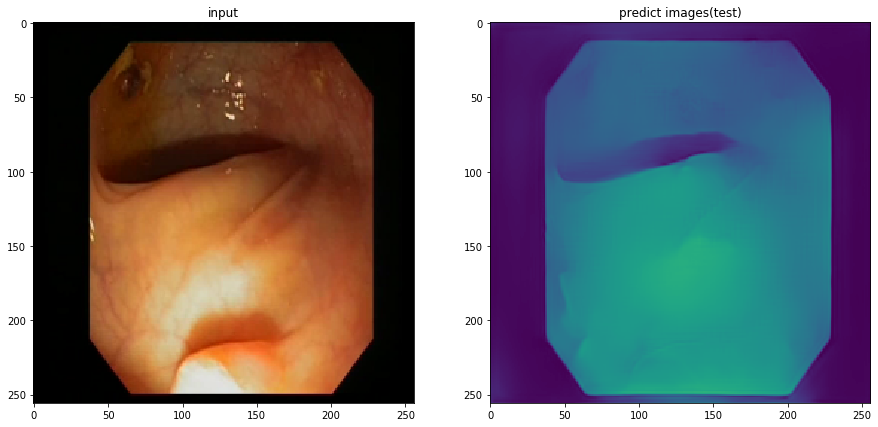

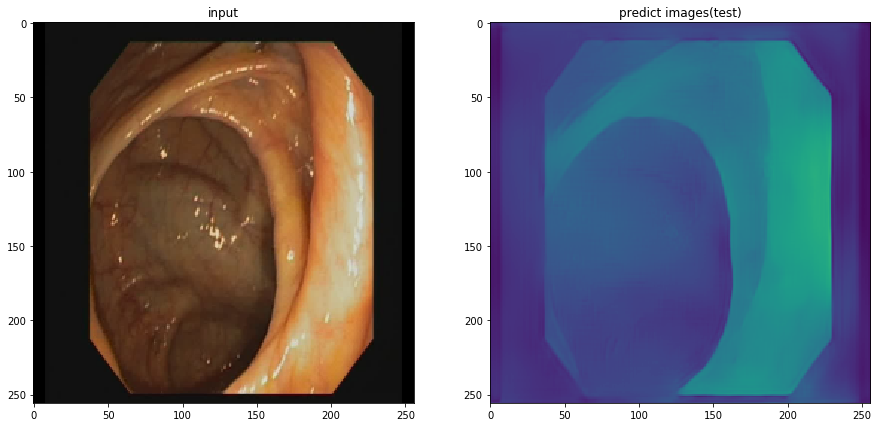

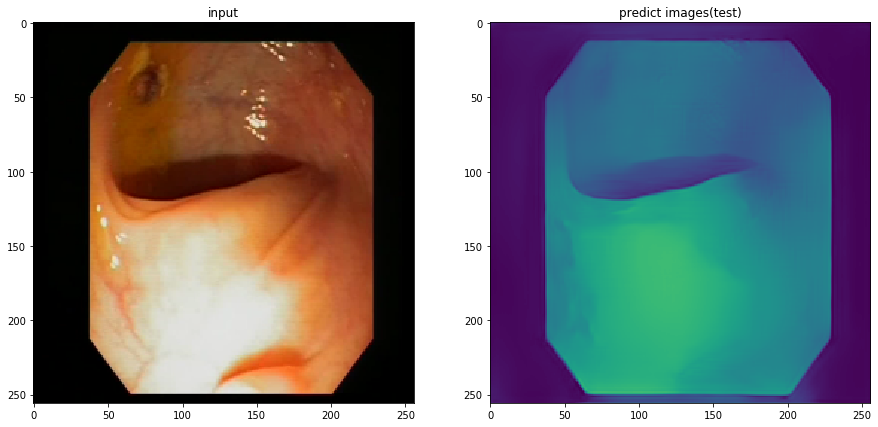

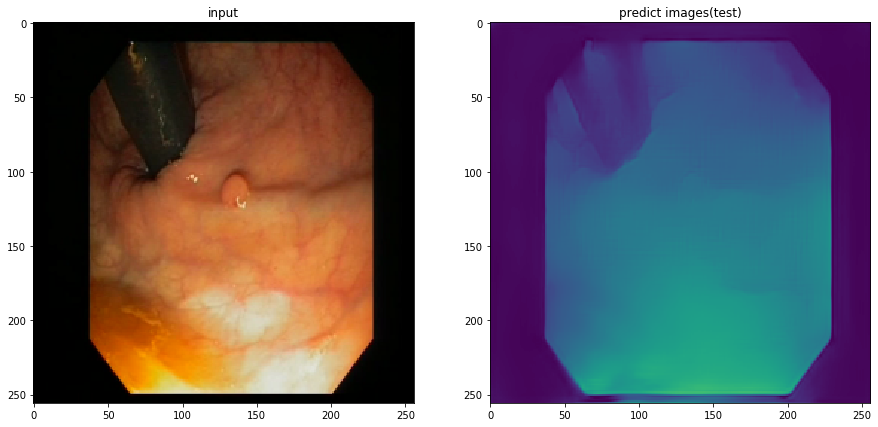

In [23]:
frame_list = glob.glob(os.path.join(path, '*.png'))
rand_list = random.sample(frame_list, 10)
for tmp in rand_list:
    img = np.expand_dims(cv2.resize(np.array(Image.open(tmp))/255., (256,256)), axis=0)
    test_p = model.predict(img)
    plt.figure(figsize=(15, 15))
    plt.subplot(121)
    plt.imshow(img[0])
    plt.title("input")
    plt.subplot(122)
    plt.imshow(np.reshape(1- test_p[0][0]*scale,(256,256)),vmin = 0, vmax = 1, cmap = 'viridis')
    plt.title("predict images(test)")
    plt.show()

In [37]:
def data_generator_test(data_path, batch, strat_frame, skip_frame, aug):
    dir_list = os.listdir(data_path)
    img_list = []
    for j in dir_list:
        img_path = os.path.join(data_path, j)
        tmp_list = sorted(glob.glob(img_path +'/*.png'))
        img_list += tmp_list
    img_list = img_list[strat_frame:]
    idx = 0
    while 1:
        idx_list = list(range(0,len(img_list),skip_frame))
        bat_img = []
        bat_lab = []
        if idx > len(idx_list) - batch:
            idx = idx_list[idx:]
            idx = 0
        else:
            tmp_list = idx_list[idx:idx+batch]
            idx = idx + batch
            
        for i in tmp_list:
            img_tmp = cv2.imread(img_list[i])
            
            if img_tmp is None:
                print(img_list[i])
            if aug == 1:    
                img = augment_image_colorspace(cv2.cvtColor(img_tmp[:,:256,:],cv2.COLOR_BGR2RGB)/255.)
            else:
                img = cv2.cvtColor(img_tmp[:,:256,:],cv2.COLOR_BGR2RGB)/255.
            lab = cv2.cvtColor(img_tmp[:,256:,:], cv2.COLOR_BGR2GRAY)/255.
            bat_img.append(img)
            bat_lab.append(lab) 
        yield np.array(bat_img), [np.expand_dims(np.array([cv2.resize(i, (256, 256)) for i in bat_lab]),axis = -1),
                                 np.expand_dims(np.array([cv2.resize(i, (128, 128)) for i in bat_lab]),axis = -1),
                                 np.expand_dims(np.array([cv2.resize(i, (64, 64)) for i in bat_lab]),axis = -1),
                                 np.expand_dims(np.array([cv2.resize(i, (32, 32)) for i in bat_lab]),axis = -1),]

In [49]:
test_path = '/data1/depth/endo_sim2/test/'
batch = 1
strat_frame = 1000
skip_frame = 100
test = data_generator_test(test_path, batch, strat_frame, skip_frame, 0)

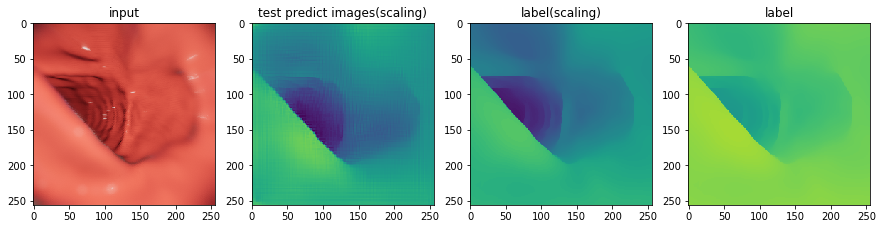

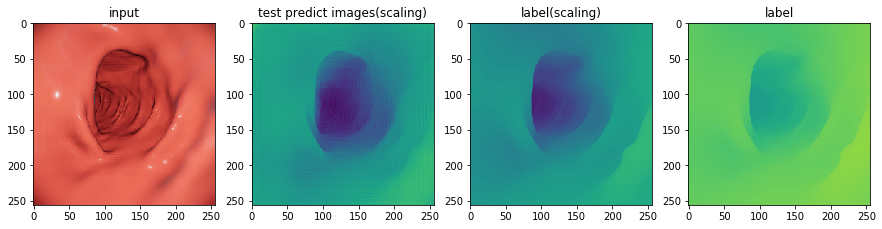

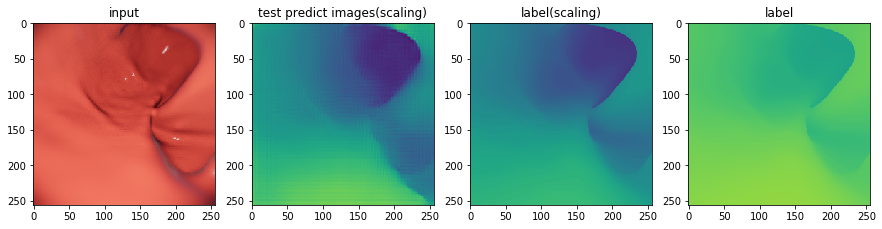

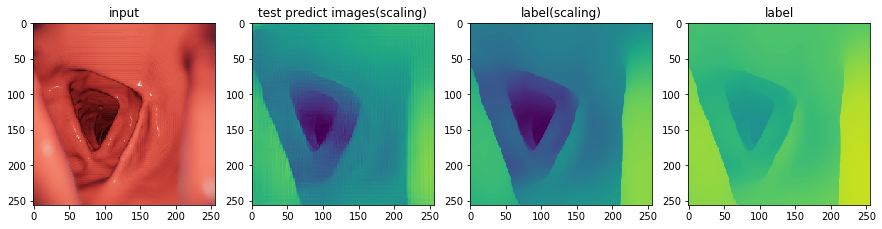

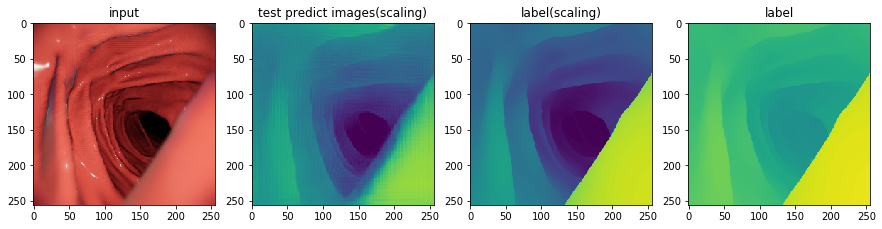

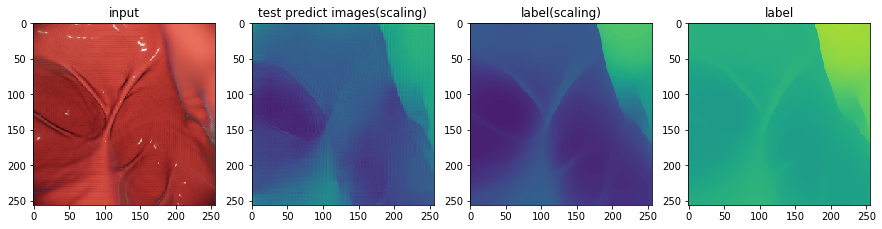

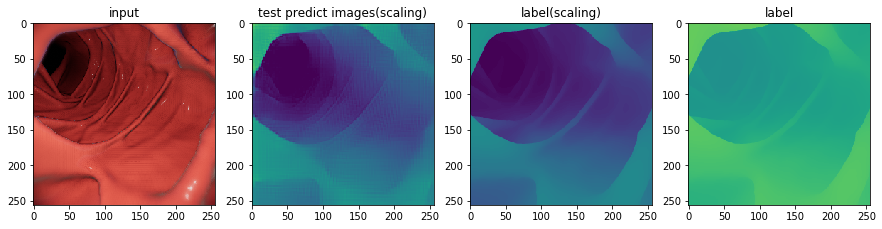

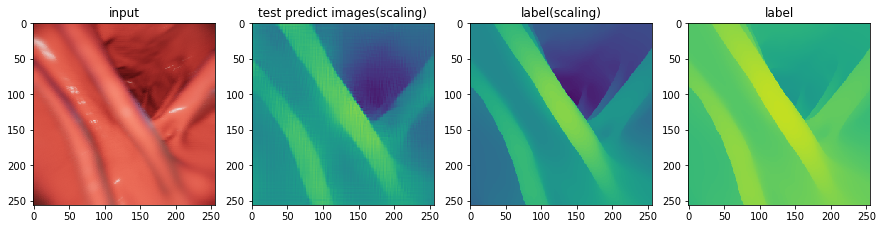

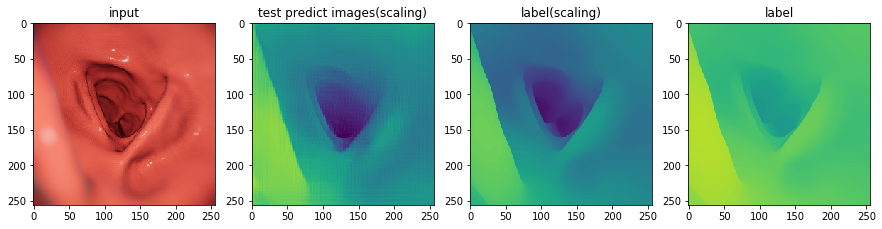

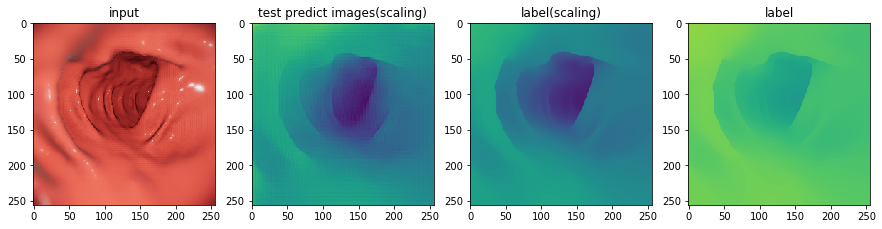

In [50]:
scale = 2
for i in range(10):
    test_img, test_lab= next(test)
    test_p = model.predict(test_img)
    plt.figure(figsize=(15, 15))
    plt.subplot(141)
    plt.imshow(test_img[0])
    plt.title("input")
    plt.subplot(142)
    plt.imshow(1-np.reshape(test_p[0][0]*scale,(256,256)),vmin = 0, vmax = 1, cmap = 'viridis')
    plt.title("test predict images(scaling)")
    plt.subplot(143)
    plt.imshow(1-np.reshape(test_lab[0][0]*scale,(256,256)),vmin = 0, vmax = 1, cmap = 'viridis')
    plt.title("label(scaling)")
    plt.subplot(144)
    plt.imshow(1-np.reshape(test_lab[0][0], (256,256)),vmin = 0, vmax = 1, cmap = 'viridis')
    plt.title("label")
    plt.show()